In [1]:
import numpy as np
import dapy.inference as da
from dapy.models.linear import generate_random_parameters, LinearGaussianModel
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.linalg as la
%matplotlib inline
sns.set_style('white')

## Model

Dynamic system with linear dynamics and observations and additive Gaussian noise. System dynamics are of the form

\begin{align}
  \boldsymbol{z}[t] &= \mathbf{F}\mathbf{z}[t-1] + \mathbf{G}\boldsymbol{u}[t]\\
  \boldsymbol{x}[t] &= \mathbf{H}\boldsymbol{z}[t] + \mathbf{J}\boldsymbol{v}[t]\\
\end{align}

where

  * $\boldsymbol{z}[t] \in \mathbb{R}^{D_{\boldsymbol{z}}}$ : state at time index $t$,
  * $\boldsymbol{x}[t] \in \mathbb{R}^{D_{\boldsymbol{x}}}$ : observations at time index $t$,
  * $\boldsymbol{u}[t] \in \mathbb{R}^{D_{\boldsymbol{z}}}$ : additive state noise at time index $t$ $\sim \mathcal{N}(\cdot \,|\, \boldsymbol{0},\mathbf{I})$,
  * $\boldsymbol{v}[t] \in \mathbb{R}^{D_{\boldsymbol{z}}}$ : additive observation noise at time index $t$ $\sim \mathcal{N}(\cdot \,|\, \boldsymbol{0},\mathbf{I})$,
  
and with initial state distribution

\begin{equation}
  \boldsymbol{z}[0] \sim \mathcal{N}(\cdot \,|\, \boldsymbol{m},\mathbf{C}).
\end{equation}

In [2]:
dim_z = 10
dim_x = 5
n_steps = 100
seed = 123456
rng = np.random.RandomState(seed)
params = generate_random_parameters(dim_z, dim_x, rng)

In [3]:
model = LinearGaussianModel(rng=rng, **params)

## Generate data from model

In [4]:
z_reference, x_reference = model.generate(n_steps)

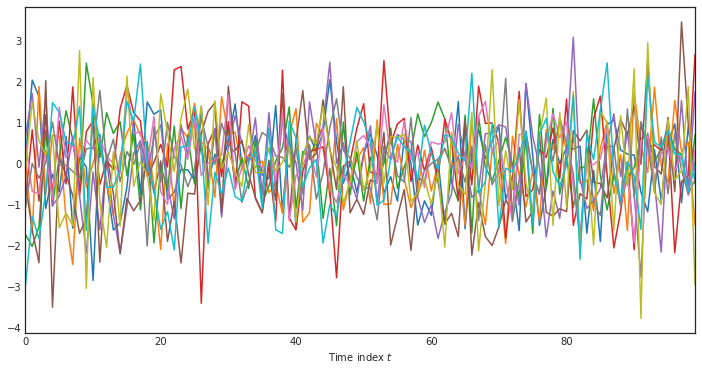

In [5]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(z_reference)
ax.set_xlabel('Time index $t$')
_ =ax.set_xlim(0, n_steps - 1)

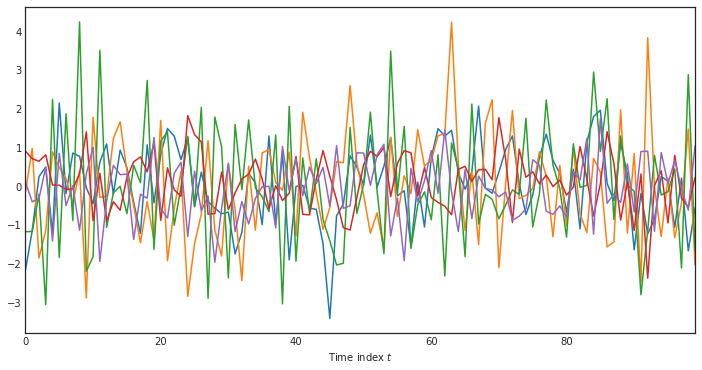

In [6]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_reference)
ax.set_xlabel('Time index $t$')
_ =ax.set_xlim(0, n_steps - 1)

## Infer state from observations

### Exact Kalman filter

In [7]:
kf = da.KalmanFilter(
    model.init_state_mean, model.init_state_covar, 
    model.state_trans_matrix, model.state_noise_matrix, 
    model.observation_matrix, model.obser_noise_matrix
)

In [8]:
%%time
results_kf = kf.filter(x_reference)

CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 35.5 ms


### Ensemble Kalman filter (perturbed observations)

In [9]:
enkf = da.EnsembleKalmanFilter(
    model.init_state_sampler, model.next_state_sampler, 
    model.observation_sampler, rng
)

In [10]:
%%time
results_enkf = enkf.filter(x_reference, 500)

CPU times: user 220 ms, sys: 8 ms, total: 228 ms
Wall time: 118 ms


### Ensemble Kalman filter (square root)

In [11]:
esrf = da.EnsembleSquareRootFilter(
    model.init_state_sampler, model.next_state_sampler, 
    model.observation_matrix, model.obser_noise_matrix, 
    rng
)

In [12]:
%%time
results_esrf = esrf.filter(x_reference, 500, True)

CPU times: user 7.14 s, sys: 60 ms, total: 7.2 s
Wall time: 3.63 s


### Ensemble Kalman filter (square root using Woodbury matrix inverse identity)

In [13]:
obser_covar_matrix = params['obser_noise_matrix'].dot(params['obser_noise_matrix'].T)
obser_preci_matrix = la.inv(obser_covar_matrix)
wesrf = da.WoodburyEnsembleSquareRootFilter(
    model.init_state_sampler, model.next_state_sampler, 
    model.observation_matrix, obser_preci_matrix, 
    rng
)

In [14]:
%%time
results_wesrf = wesrf.filter(x_reference, 500, True)

CPU times: user 12.4 s, sys: 236 ms, total: 12.6 s
Wall time: 6.51 s


### Bootstrap particle filter

In [15]:
bspf = da.BootstrapParticleFilter(
    model.init_state_sampler, model.next_state_sampler, 
    model.log_prob_dens_obs_gvn_state, rng
)

In [16]:
%%time
results_bspf = bspf.filter(x_reference, 500)

CPU times: user 320 ms, sys: 20 ms, total: 340 ms
Wall time: 193 ms


### Ensemble transform particle filter

In [17]:
etpf = da.EnsembleTransformParticleFilter(
    model.init_state_sampler, model.next_state_sampler, 
    model.log_prob_dens_obs_gvn_state, rng
)

In [18]:
%%time
results_etpf = etpf.filter(x_reference, 500)

CPU times: user 8.57 s, sys: 452 ms, total: 9.02 s
Wall time: 4.6 s


### Visualise estimated means of filtering distribution

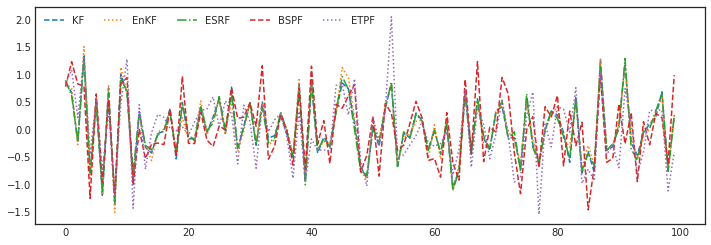

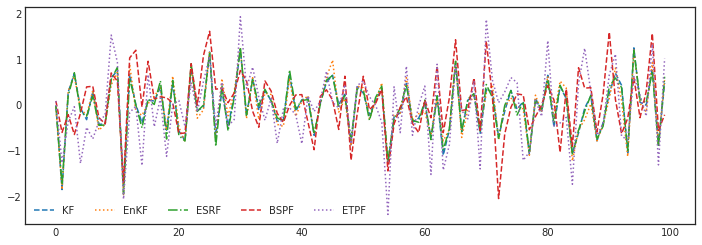

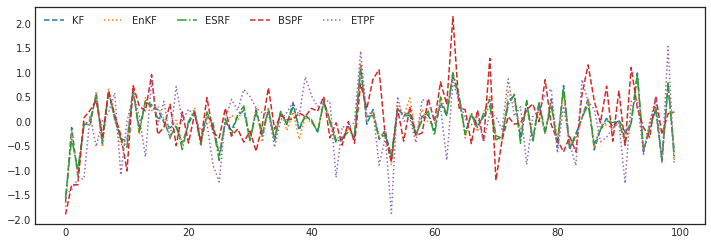

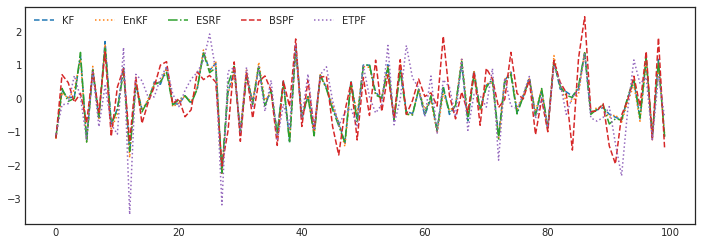

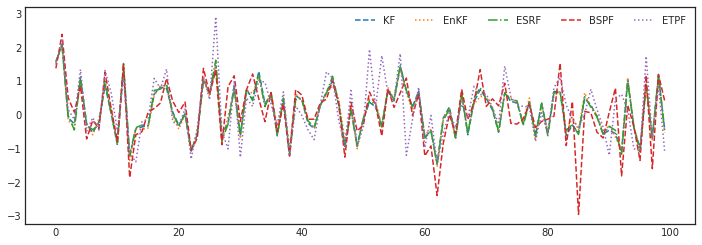

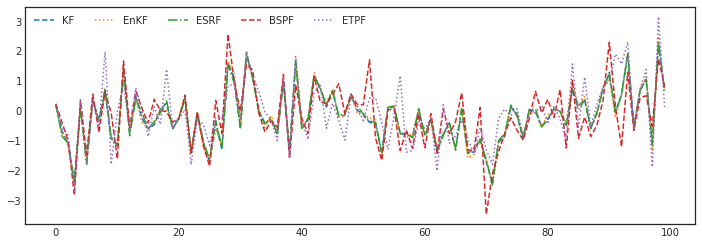

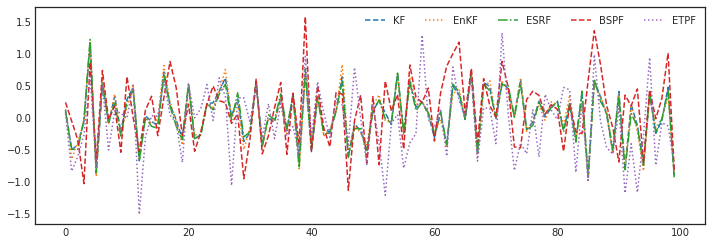

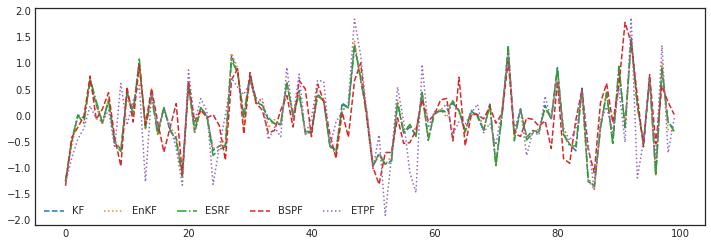

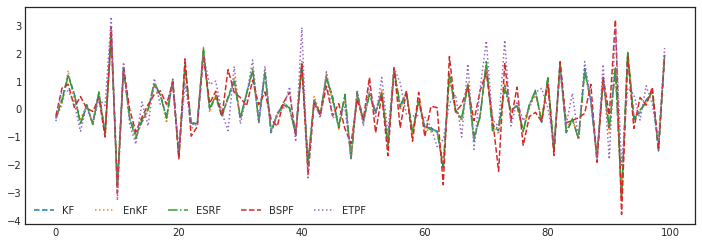

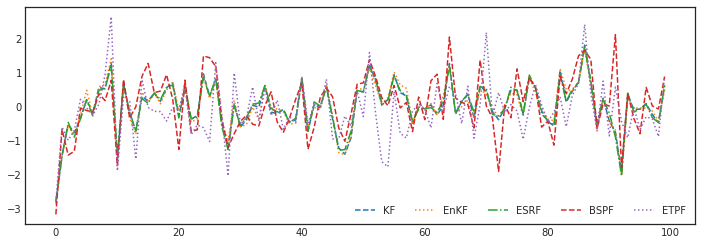

In [19]:
for i in range(dim_z):
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 1, 1)
    #ax.plot(z_reference[:, i], 'k', label='True')
    ax.plot(results_kf['z_mean_seq'][:, i], '--', label='KF')
    ax.plot(results_enkf['z_mean_seq'][:, i], ':', label='EnKF')
    ax.plot(results_esrf['z_mean_seq'][:, i], '-.', label='ESRF')
    #ax.plot(results_wesrf['z_mean_seq'][:, i], '-', label='wESRF')
    ax.plot(results_bspf['z_mean_seq'][:, i], '--', label='BSPF')
    ax.plot(results_etpf['z_mean_seq'][:, i], ':', label='ETPF')
    ax.legend(ncol=8)